# Problem Statement

Install Kaggle + Upload API Key

In [1]:
# Install kaggle
!pip install kaggle

# Upload token
from google.colab import files
files.upload()

# Configure access

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



Saving kaggle.json to kaggle.json


# Download Dataset

In [2]:
# dataset name
#demand-forecasting-kernels-only

!kaggle competitions download -c demand-forecasting-kernels-only
!unzip demand-forecasting-kernels-only.zip


  0% 0.00/3.29M [00:00<?, ?B/s]
100% 3.29M/3.29M [00:00<00:00, 1.28GB/s]
Archive:  demand-forecasting-kernels-only.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


Load and inspect the dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv("train.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["store", "item", "date"])

print(df.head())
df.shape



        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10


(913000, 4)

In [4]:
# Quick checks
print("Date range:", df["date"].min(), "to", df["date"].max())
print("Stores:", df["store"].nunique(), "Items:", df["item"].nunique())
print("Missing values:\n", df.isna().sum())

Date range: 2013-01-01 00:00:00 to 2017-12-31 00:00:00
Stores: 10 Items: 50
Missing values:
 date     0
store    0
item     0
sales    0
dtype: int64


In [5]:
# Pick one series (store 1, item 1)
store_id, item_id = 1, 1
series = df[(df["store"] == store_id) & (df["item"] == item_id)][["date","sales"]].copy()
series = series.set_index("date").asfreq("D")  # daily frequency
series.head(), series.shape



(            sales
 date             
 2013-01-01     13
 2013-01-02     11
 2013-01-03     14
 2013-01-04     13
 2013-01-05     10,
 (1826, 1))

Visualizing Daily Demand — Store

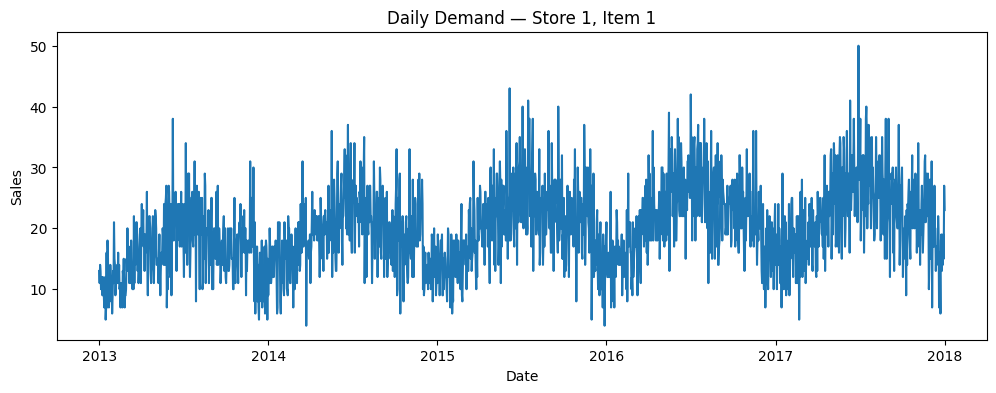

In [6]:
# Daily Demand — Store
plt.figure(figsize=(12,4))
plt.plot(series.index, series["sales"])
plt.title(f"Daily Demand — Store {store_id}, Item {item_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

Time-based train/test split (last 90 days test)

In [7]:
h = 90  # forecast horizon
train = series.iloc[:-h].copy()
test  = series.iloc[-h:].copy()

print("Train:", train.index.min(), "to", train.index.max(), "| n=", len(train))
print("Test :", test.index.min(),  "to", test.index.max(),  "| n=", len(test))


Train: 2013-01-01 00:00:00 to 2017-10-02 00:00:00 | n= 1736
Test : 2017-10-03 00:00:00 to 2017-12-31 00:00:00 | n= 90


Baseline forecast (Naive / persistence)

In [8]:
# Baseline forecast (Naive / persistence)
naive_pred = test["sales"].shift(1)
naive_pred.iloc[0] = train["sales"].iloc[-1]

# Metrics
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.where(denom == 0, 1, denom)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

mae = mean_absolute_error(test["sales"], naive_pred)
rmse = np.sqrt(mean_squared_error(test["sales"], naive_pred))
s = smape(test["sales"], naive_pred)

print("NAIVE BASELINE")
print("MAE :", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("SMAPE (%):", round(s, 3))


NAIVE BASELINE
MAE : 5.944
RMSE: 7.36
SMAPE (%): 31.31


This is a valid forecasting benchmark, which serves as the performance floor. We aim to build forcasting models that beat:
- MAE = 5.944
- RMSE = 7.36
- SMAPE = 31.31%

Visualizing forecast (naive) vs actual

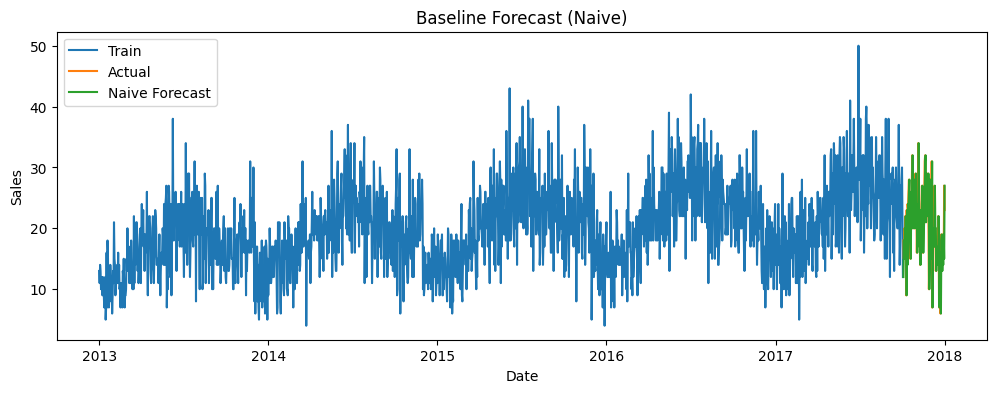

In [9]:
plt.figure(figsize=(12,4))
plt.plot(train.index, train["sales"], label="Train")
plt.plot(test.index, test["sales"], label="Actual")
plt.plot(test.index, naive_pred, label="Naive Forecast")
plt.title("Baseline Forecast (Naive)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


Seasonality snapshot

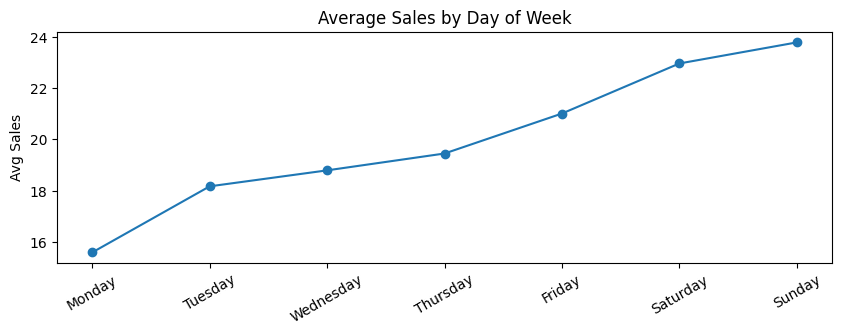

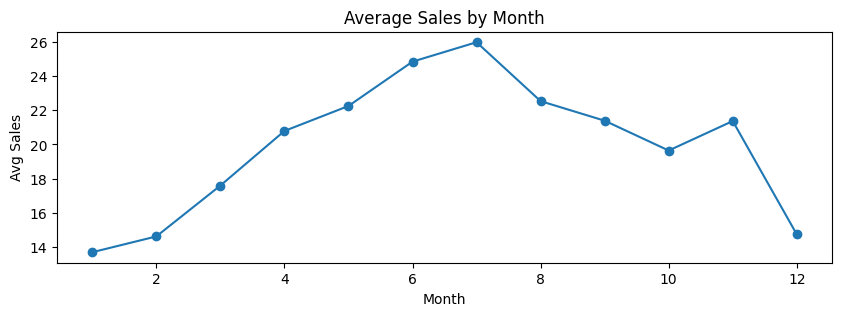

In [10]:
# Seasonality snapshot

tmp = series.copy()
tmp["dow"] = tmp.index.day_name()
tmp["month"] = tmp.index.month

dow_mean = tmp.groupby("dow")["sales"].mean().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)
month_mean = tmp.groupby("month")["sales"].mean()

plt.figure(figsize=(10,3))
plt.plot(dow_mean.index, dow_mean.values, marker="o")
plt.title("Average Sales by Day of Week")
plt.xticks(rotation=30)
plt.ylabel("Avg Sales")
plt.show()

plt.figure(figsize=(10,3))
plt.plot(month_mean.index, month_mean.values, marker="o")
plt.title("Average Sales by Month")
plt.xlabel("Month")
plt.ylabel("Avg Sales")
plt.show()


Next, we will build forecasting models. We will build models in increasing sophistication:
- Moving Average Forecast
- Machine Learning model with lag features
- Compare performance
- Visual comparison

#  Model 1 — Moving Average Forecast

Predict tomorrow = average of last k days.

We’ll try 7-day window (weekly seasonality).

In [11]:
# Moving Average Forecast

window = 7

ma_pred = test["sales"].copy()

history = train["sales"].tolist()

for t in range(len(test)):
    forecast = np.mean(history[-window:])
    ma_pred.iloc[t] = forecast
    history.append(test["sales"].iloc[t])


/tmp/ipython-input-4293709384.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22.714285714285715' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ma_pred.iloc[t] = forecast


Evaluate moving average

In [12]:
ma_mae = mean_absolute_error(test["sales"], ma_pred)
ma_rmse = np.sqrt(mean_squared_error(test["sales"], ma_pred))
ma_smape = smape(test["sales"], ma_pred)

print("MOVING AVERAGE MODEL")
print("MAE :", round(ma_mae,3))
print("RMSE:", round(ma_rmse,3))
print("SMAPE:", round(ma_smape,3))


MOVING AVERAGE MODEL
MAE : 4.34
RMSE: 5.502
SMAPE: 22.452


Naive vs Moving Average Forecast

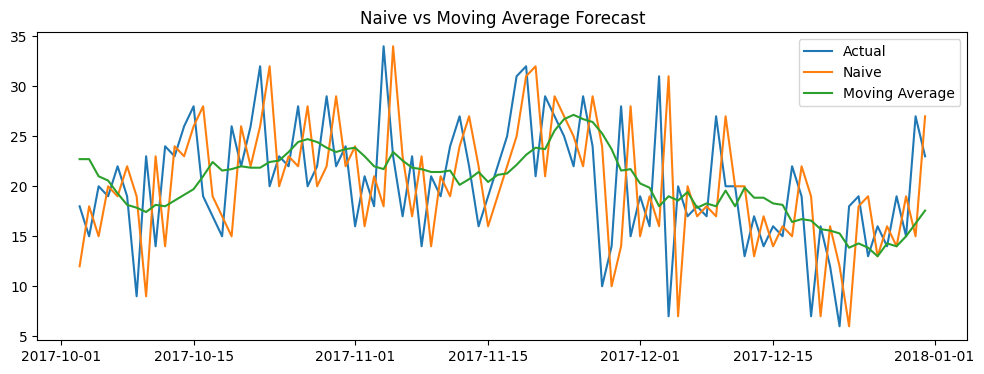

In [13]:
# Naive vs Moving Average Forecast

plt.figure(figsize=(12,4))
plt.plot(test.index, test["sales"], label="Actual")
plt.plot(test.index, naive_pred, label="Naive")
plt.plot(test.index, ma_pred, label="Moving Average")
plt.legend()
plt.title("Naive vs Moving Average Forecast")
plt.show()


# Model 2 — Machine Learning with Lag Features

The key here is that we convert time series → supervised learning.

The features include:

lag 1 day

lag 7 days

lag 30 days

rolling mean

rolling std

Create lag features

In [14]:
# Create lag features
data = series.copy()

data["lag_1"] = data["sales"].shift(1)
data["lag_7"] = data["sales"].shift(7)
data["lag_30"] = data["sales"].shift(30)

data["rolling_mean_7"] = data["sales"].shift(1).rolling(7).mean()
data["rolling_std_7"] = data["sales"].shift(1).rolling(7).std()

data = data.dropna()
data.head()


,sales,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7
date,,,,,,
2013-01-31,13,9.0,8.0,13.0,10.285714,2.751623
2013-02-01,11,13.0,14.0,11.0,11.000000,2.708013
2013-02-02,21,11.0,12.0,14.0,10.571429,2.370453
2013-02-03,15,21.0,12.0,13.0,11.857143,4.634241
2013-02-04,14,15.0,11.0,10.0,12.285714,4.785892


Train/test split again

In [15]:
# Train/test split again

train_ml = data.iloc[:-90]
test_ml = data.iloc[-90:]

X_train = train_ml.drop("sales", axis=1)
y_train = train_ml["sales"]

X_test = test_ml.drop("sales", axis=1)
y_test = test_ml["sales"]


Train regression model

We use Random Forest (works great for tabular).

In [16]:
# Train regression model
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)


Evaluate ML forecast

In [17]:
# Evaluate ML Model
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_smape = smape(y_test, rf_pred)

print("RANDOM FOREST MODEL")
print("MAE :", round(rf_mae,3))
print("RMSE:", round(rf_rmse,3))
print("SMAPE:", round(rf_smape,3))


RANDOM FOREST MODEL
MAE : 4.295
RMSE: 5.371
SMAPE: 22.585


Forecast Model Comparison

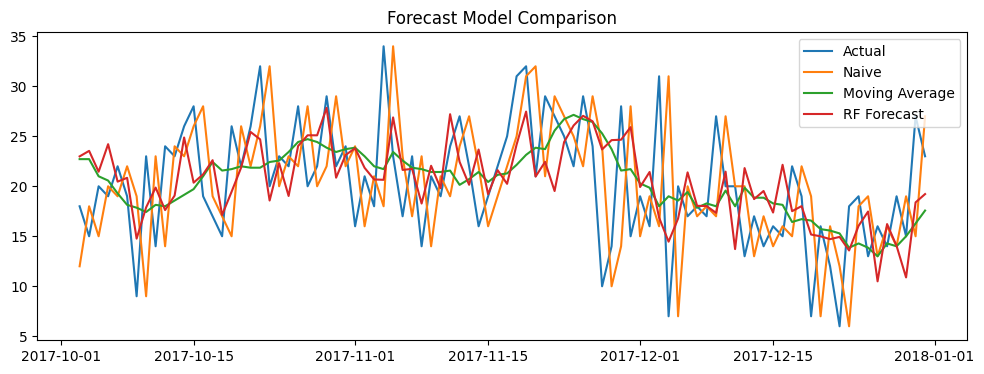

In [18]:
# Forecast Model Comparison
plt.figure(figsize=(12,4))
plt.plot(test.index, test["sales"], label="Actual")
plt.plot(test.index, naive_pred, label="Naive")
plt.plot(test.index, ma_pred, label="Moving Average")
plt.plot(test_ml.index, rf_pred, label="RF Forecast")
plt.legend()
plt.title("Forecast Model Comparison")
plt.show()


# Findings

Both forecasting models substantially outperformed the naive baseline, demonstrating strong predictive capability on the retail demand time series. The Random Forest model achieved the lowest MAE and RMSE, indicating the best overall predictive accuracy, while the moving average model remained highly competitive, effectively capturing the underlying seasonality in demand. Compared to the naive forecast, the Random Forest model reduced mean absolute error from 5.944 to 4.295 — an improvement of approximately 27.7%, showing that machine learning significantly improves demand prediction accuracy over simple persistence-based forecasting.

# Inventory Optimization (Newsvendor Model)

Up to now, we predicted demand. But businesses don’t just want predictions they want decisions: How much inventory should we order?

Ordering too much wastes money (holding cost).
Ordering too little loses sales (stockout cost).

The optimal order quantity balances these two risks.

# Conceptual Overview
Here, we will build newsvendor model. The newsvendor model determines the optimal inventory level by balancing the cost of excess inventory against the cost of unmet demand. When stockout costs are higher than holding costs, the optimal policy favors ordering more inventory to reduce lost sales. The optimal order quantity is determined by the critical ratio, which represents the probability that demand will not exceed the order quantity.

Implementation

We now convert the demand forecasts into inventory decisions. First, we define business cost structure using realistic but interpretable values.

 Interpretation:
If stockouts are expensive, order more inventory.

In [19]:
holding_cost = 1      # cost to hold one extra unit
stockout_cost = 5     # cost of unmet demand

critical_ratio = stockout_cost / (stockout_cost + holding_cost)
print("Critical ratio:", critical_ratio)


Critical ratio: 0.8333333333333334


Thus, optimal inventory is the 83rd percentile of demand.

Next, we use best demand forecast.From earlier results, Random Forest performed best.

In [22]:
# predicted demand distribution
forecast_demand = rf_pred

# Compute optimal order quantity
optimal_inventory = np.quantile(forecast_demand, critical_ratio)
print("Optimal inventory level:", round(optimal_inventory,2))


Optimal inventory level: 24.45


This is the recommended daily order quantity.

 Next, we define naive policy (benchmark).

Simple but common real-world approach: Order average demand.

In [24]:
# Naive inventory level
naive_inventory = np.mean(forecast_demand)
print("Naive inventory level:", round(naive_inventory,2))


Naive inventory level: 20.52


Next, we compare the policies.


Real operational cost Simulation

We evaluate decisions using actual demand.

In [25]:
def inventory_cost(actual_demand, inventory):
    holding = np.maximum(inventory - actual_demand, 0)
    stockout = np.maximum(actual_demand - inventory, 0)

    total_cost = (
        holding.sum() * holding_cost +
        stockout.sum() * stockout_cost
    )
    return total_cost


Optimal vs naive strategy

In [26]:
# Compare optimal vs naive strategy
actual = y_test.values

cost_optimal = inventory_cost(actual, optimal_inventory)
cost_naive = inventory_cost(actual, naive_inventory)

print("Optimal policy cost:", round(cost_optimal,2))
print("Naive policy cost :", round(cost_naive,2))

improvement = (cost_naive - cost_optimal) / cost_naive * 100
print("Cost reduction (%):", round(improvement,2))


Optimal policy cost: 840.42
Naive policy cost : 1220.43
Cost reduction (%): 31.14


# Results

The newsvendor model was applied to convert demand forecasts into optimal inventory decisions by balancing holding and stockout costs. Using a cost ratio that prioritizes avoiding stockouts, the optimal inventory level was determined as the 83rd percentile of forecasted demand. This resulted in an optimal daily inventory level of 24.45 units, compared to 20.52 units under a naive average-demand strategy. Simulation using actual demand showed that the optimized policy reduced total operational cost from 1220.43 to 840.42, representing a 31.14% cost reduction. This demonstrates how predictive demand models can be translated into economically optimal inventory policies that significantly improve operational efficiency.